# Initialize Notebook

## Download Data and Packages

In [ ]:
# !wget https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/train_images.zip
# !wget https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/train_annotation.json
# !wget https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/test_images.zip

--2024-07-04 03:00:19--  https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/train_images.zip
Resolving solafune-dev-v1.s3.us-west-2.amazonaws.com (solafune-dev-v1.s3.us-west-2.amazonaws.com)... 3.5.87.213, 52.92.235.18, 52.92.145.218, ...
Connecting to solafune-dev-v1.s3.us-west-2.amazonaws.com (solafune-dev-v1.s3.us-west-2.amazonaws.com)|3.5.87.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1275291229 (1.2G) [application/zip]
Saving to: ‘train_images.zip’

train_images.zip    100%[===================>]   1.19G  44.6MB/s    in 29s     

2024-07-04 03:00:49 (41.8 MB/s) - ‘train_images.zip’ saved [1275291229/1275291229]

--2024-07-04 03:00:49--  https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/train_annotation.json
Resolving solafune-dev-v1.s3.us-west-2.amazonaws.com (solafune-dev-v1.s3.us-west-2.amazonaws.com)... 52.218.181.41, 52.218.253.41, 3.5.86.236, ...
Connecting to solafune-dev-v1.s3.us

In [ ]:
# !unzip -q "/content/train_images.zip" -d /content/train_images
# !unzip -q "/content/test_images.zip" -d /content/test_images

In [ ]:
# !pip install imagecodecs==2024.1.1
# !pip install rasterio -q
# !pip install geopandas -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 37.4 MB/s eta 0:00:00


## Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pltPatches
import imagecodecs
import tifffile
import json
import shapely

import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, maskrcnn_resnet50_fpn
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import MaskRCNN as MaskRCNNPT
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, _resnet_fpn_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNNHeads
from torchvision.models.detection.faster_rcnn import _default_anchorgen, FasterRCNN, FastRCNNConvFCHead, RPNHead

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf

import random
import rasterio

from shapely.geometry import Polygon
from tqdm import tqdm
import geopandas as gpd

In [ ]:
%load_ext tensorboard

# Constants

In [ ]:
# From EDA
UNSCALED_MAX_PER_CHANNEL = np.array([5333, 7568, 7820, 8216, 8521.5, 8184.5, 8087.66666667, 9544, 8850, 7409.5, 8026, 7800])
UNSCALED_MIN_PER_CHANNEL = np.array([314.5, 329.81818182, 594.23076923, 407.62962963, 940, 1123.25, 1215.33333333, 1027, 1452, 2193, 1588, 985.75])
UNSCALED_MEAN_PER_CHANNEL = np.array([464.70121204, 598.62699975, 891.91317792, 1012.85800414, 1421.28379787, 2295.8051439, 2598.71698689, 2746.8287079, 2829.87869634, 2858.89452691, 2430.81268143, 1759.55991799])
UNSCALED_STD_PER_CHANNEL = np.array([217.28128051, 309.23386134, 393.32162259, 583.14269819, 562.69021279, 648.57382201, 740.24052779, 783.49662998, 775.56858831, 752.62297522, 760.89189569, 754.91138989])

SCALED_MEAN_PER_CHANNEL = np.array([0.02991286, 0.03712551, 0.04117549, 0.07749634, 0.06344841, 0.16601265, 0.20125055, 0.2018969, 0.18619803, 0.12753993, 0.13084667, 0.11351918])
SCALED_STD_PER_CHANNEL = np.array([0.04329605, 0.04272258, 0.05443317, 0.07468174, 0.07421884, 0.09184969, 0.1077131, 0.09199207, 0.10483486, 0.14427731, 0.11818758, 0.11078421])

TRAIN_PATH = "/content/train_images/images/"
TEST_PATH = "/content/test_images/images/"
TRAIN_PATH_JSON = "/content/train_annotation.json"
TRAIN_IMG_FILE_NAMES = np.array([f for f in os.listdir(TRAIN_PATH) if f.endswith('.tif') or f.endswith('.tiff')])
TEST_IMG_FILE_NAMES = np.array([f for f in os.listdir(TEST_PATH) if f.endswith('.tif') or f.endswith('.tiff')])

SMALL_IMAGES = TRAIN_IMG_FILE_NAMES[[0, 1, 3, 4, 8, 9, 10, 12, 13, 20, 21, 23, 24, 26, 29, 30, 31, 33, 35, 36, 39, 42, 46, 47]]
MED_IMAGES = TRAIN_IMG_FILE_NAMES[[2, 7, 14, 15, 16, 17, 19, 22, 25, 27, 32, 37, 40, 41, 43, 44, 45, 48]]
LARGE_IMAGES = TRAIN_IMG_FILE_NAMES[[5, 6, 11, 18, 28, 34, 38, 49]]

In [ ]:
# Stores constant values that does not change throughout dataset
class ConstantHelper():
  def __init__(self, img_dir, img_files, ann_file, skip_invalid=True):
    self.min_max_divisor = UNSCALED_MAX_PER_CHANNEL - UNSCALED_MIN_PER_CHANNEL
    self.min_max_subtractor = UNSCALED_MIN_PER_CHANNEL
    self.scaled_mean = SCALED_MEAN_PER_CHANNEL
    self.scaled_std = SCALED_STD_PER_CHANNEL
    self.skip_invalid = skip_invalid
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # load file to image dict
    self.imgs = self.load_images_to_dict(img_dir, img_files)

    # returns a dictionary of file to list of polygon annotations
    with open(ann_file, 'r') as f:
      annotations = json.load(f)
    self.img_to_ann = self.load_annotations_to_dict(annotations, set(img_files))

    # process polygons and create a file to polygons dictionary utilize large Memory
    self.img_to_poly = {}
    for i, file in enumerate(img_files):
      boxes = []
      polygons = []

      for annotation in self.img_to_ann[file]:
        segments = annotation['segmentation']
        if self.skip_invalid and self.validate_segments_polygon(segments) == False:
            continue

        polygon, box = self.extract_box_and_polygon_from_segments(segments)
        boxes.append(box)
        polygons.append(polygon)

      self.img_to_poly[file] = {'polygons': polygons, 'boxes': boxes}
      self.creat_img_horizontal_flip(file)
      self.creat_img_vertical_flip(file)
      self.creat_img_diagonal_flip(file)

  def flip_img_h(self, img):
    flipped_img_array = np.empty_like(img)
    for channel in range(12):
      flipped_img_array[channel,:,:] = np.fliplr(img[channel, :, :])
    return flipped_img_array

  def flip_img_v(self, img):
    flipped_img_array = np.empty_like(img)
    for channel in range(12):
      flipped_img_array[channel,:,:] = np.flipud(img[channel, :, :])
    return flipped_img_array

  def flip_polygons_and_boxes_horizontal(self, polygons, bounding_boxes, image_width):
    flipped_polygons = []
    flipped_boxes = []
    for polygon, box in zip(polygons, bounding_boxes):
      flipped_polygon = [(image_width - x, y) for x, y in polygon]
      flipped_polygons.append(flipped_polygon)

      xmin, ymin, xmax, ymax = box
      flipped_box = (image_width - xmax, ymin, image_width - xmin, ymax)
      flipped_boxes.append(flipped_box)
    return flipped_polygons, flipped_boxes

  def flip_polygons_and_boxes_vertical(self, polygons, bounding_boxes, image_height):
    flipped_polygons = []
    flipped_boxes = []
    for polygon, box in zip(polygons, bounding_boxes):
      x_min, y_min, x_max, y_max = box
      flipped_bbox = (x_min, image_height - y_max, x_max, image_height - y_min)
      flipped_boxes.append(flipped_bbox)

      flipped_polygon = [(x, image_height - y) for x, y in polygon]
      flipped_polygons.append(flipped_polygon)
    return flipped_polygons, flipped_boxes

  def creat_img_diagonal_flip(self, f):
    name = "{}_diagonal.tif".format(f.replace('.tif', ''))
    polygons = self.img_to_poly[f]['polygons']
    boxes = self.img_to_poly[f]['boxes']

    flipped_polygons, flipped_boxes = self.flip_polygons_and_boxes_horizontal(polygons, boxes, self.imgs[f].shape[-1])
    flipped_polygons, flipped_boxes = self.flip_polygons_and_boxes_vertical(flipped_polygons, flipped_boxes, self.imgs[f].shape[1])
    flipped_img = self.flip_img_h(self.imgs[f])
    flipped_img = self.flip_img_v(flipped_img)

    self.imgs[name] = torch.as_tensor(flipped_img, dtype=torch.float32)
    self.img_to_poly[name] = {
        'polygons': flipped_polygons,
        'boxes': flipped_boxes
    }

  def creat_img_horizontal_flip(self, f):
    name = "{}_horizontal.tif".format(f.replace('.tif', ''))
    polygons = self.img_to_poly[f]['polygons']
    boxes = self.img_to_poly[f]['boxes']

    flipped_polygons, flipped_boxes = self.flip_polygons_and_boxes_horizontal(polygons, boxes, self.imgs[f].shape[-1])
    flipped_img = self.flip_img_h(self.imgs[f])
    self.imgs[name] = torch.as_tensor(flipped_img, dtype=torch.float32)
    self.img_to_poly[name] = {
        'polygons': flipped_polygons,
        'boxes': flipped_boxes
    }

  def creat_img_vertical_flip(self, f):
    name = "{}_vertical.tif".format(f.replace('.tif', ''))
    polygons = self.img_to_poly[f]['polygons']
    boxes = self.img_to_poly[f]['boxes']

    flipped_polygons, flipped_boxes = self.flip_polygons_and_boxes_vertical(polygons, boxes, self.imgs[f].shape[1])
    flipped_img = self.flip_img_v(self.imgs[f])
    self.imgs[name] = torch.as_tensor(flipped_img, dtype=torch.float32)
    self.img_to_poly[name] = {
        'polygons': flipped_polygons,
        'boxes': flipped_boxes
    }

  def load_annotations_to_dict(self, annotations, files):
    images = annotations['images']
    file_dict = {}
    for img in images:
      if img['file_name'] in files:
        file_dict[img['file_name']] = img['annotations']
    return file_dict

  def make_polygon_coords_from_segments(self, segments):
    return np.array([(segments[i], segments[i+1]) for i in range(0, len(segments), 2)], dtype=np.int32)

  def validate_segments_polygon(self, segments):
    poly_coords = self.make_polygon_coords_from_segments(segments)
    shapPoly = shapely.geometry.Polygon(poly_coords)
    return shapPoly.is_valid

  def extract_box_and_polygon_from_segments(self, segments, scaling=1):
    px = [segments[i] * scaling + 0.5 for i in range(0, len(segments), 2)]
    py = [segments[i+1] * scaling + 0.5 for i in range(0, len(segments), 2)]
    poly = np.array([[x, y] for x, y in zip(px, py)], dtype=np.int32)
    box = [min(px), min(py), max(px), max(py)]
    return poly, box

  def preprocess_img(self, img_dir, img_file, scaling=1):
    img = tifffile.imread(os.path.join(img_dir, img_file))
    img = np.divide(np.subtract(img, self.min_max_subtractor[np.newaxis, np.newaxis, :]),
                    self.min_max_divisor[np.newaxis, np.newaxis, :])
    for i in range(img.shape[-1]):
      img[:,:,i] = np.nan_to_num(img[:,:,i], nan=SCALED_MEAN_PER_CHANNEL[i])
    transforms = T.Compose([T.ToTensor(),
                            T.Resize((img.shape[0] * scaling, img.shape[1] * scaling))])
    img = transforms(img).float()
    return img

  def load_images_to_dict(self, img_dir, img_files):
    img_dict = {}
    for f in img_files:
      img = self.preprocess_img(img_dir, f)
      img_dict[f] = img.to('cpu')
    return img_dict

  def get_processed_img(self, filename, channels):
    return self.imgs[filename][channels, :, :]

In [ ]:
CONSTANT_HELPER = ConstantHelper(TRAIN_PATH, TRAIN_IMG_FILE_NAMES, TRAIN_PATH_JSON)

In [ ]:
AUGMENTED_TRAIN_IMAGE_FILE_NAMES = []
for f in TRAIN_IMG_FILE_NAMES:
  AUGMENTED_TRAIN_IMAGE_FILE_NAMES.append(f)
  AUGMENTED_TRAIN_IMAGE_FILE_NAMES.append("{}_horizontal.tif".format(f.replace(".tif", "")))
  AUGMENTED_TRAIN_IMAGE_FILE_NAMES.append("{}_vertical.tif".format(f.replace(".tif", "")))
  AUGMENTED_TRAIN_IMAGE_FILE_NAMES.append("{}_diagonal.tif".format(f.replace(".tif", "")))

# Helper Functions

In [ ]:
def visualize_image(image):
  num_bands = image.shape[2]  # Assuming the third dimension is the number of bands
  fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # Create a 3x4 grid of subplots

  for i in range(num_bands):
    row = i // 4
    col = i % 4
    img = np.nan_to_num(np.interimage[:,:,i], nan=255)
    axs[row, col].imshow(img, cmap='gray')  # Display each band as grayscale
    axs[row, col].set_title(f'Band {i+1}')
    axs[row, col].axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
def mask_to_polygons(mask):
    contours, _ = cv2.findContours((mask.numpy() > 0.5).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    predicted_polygon = [ np.squeeze(contour, axis=1) for contour in contours if contour.shape[0] >= 3]
    predicted_polygon = [ po for po in predicted_polygon if (shapely.geometry.Polygon(po).area >= 100 and shapely.geometry.Polygon(po).is_valid)]
    predicted_polygon = [ ((np.concatenate(po).astype(float) - 0.5)).tolist() for po in predicted_polygon ]
    return predicted_polygon

In [ ]:
def compare_image_and_bounds(image, polygons=None, bbox=None):
  fig, axs = plt.subplots(ncols=2, figsize=(15, 36))

  axs[0].imshow(image.read(3))
  axs[0].set_title(f'Original')
  axs[0].axis('off')

  axs[1].imshow(image.read(3))
  axs[1].set_title(f'Prediction')
  axs[1].axis('off')

  if polygons is not None:       # Draw polygons
    features = []
    for polygon in polygons:
      pts = []
      for i in range(0, len(polygon), 2):
        pts.append([polygon[i], polygon[i+1]])
      # axs[1].add_patch(pltPatches.Polygon(pts, closed=True, linewidth=1, edgecolor='b', facecolor='none', alpha = 0.5))
      features.append({
        "type": "Feature",
        "geometry": {
          "type": "Polygon",
          "coordinates": [pts]
        },
        "properties": {"class": "field"}
      })
    if(len(features)):
      gdf = gpd.GeoDataFrame.from_features({ "type": "FeatureCollection", "features": features})
      gdf.boundary.plot(ax=axs[1], color='red')
  plt.tight_layout()
  plt.show()

def visualize_prediction(model, channels, img_path, img_file, threshold=0.0, save_to_pdf=False):
  img = CONSTANT_HELPER.preprocess_img(img_path, img_file)[channels, :, :]
  model.eval()
  with torch.no_grad():
    pred = model([img.to(CONSTANT_HELPER.device)])

  scores = pred[0]['scores']
  masks = pred[0]['masks'].squeeze(1)
  print(len(masks))
  polygons = []
  for mask_idx in range(len(masks)):
    mask = masks[mask_idx].cpu()
    score = scores[mask_idx].cpu()
    if score > threshold:
      for polygon in mask_to_polygons(mask):
        polygons.append(polygon)
  compare_image_and_bounds(rasterio.open(os.path.join(img_path, img_file)), polygons=polygons)

## For submitting to Solafune

In [ ]:
def load_file(file_path) -> str:
  try:
    with open(file_path, 'r') as file:
      return json.load(file)
  except Exception as e:
    return "File not found or not a json format"

def check_dict(pdict : dict) -> str:
  image_names = [f'test_{x}.tif' for x in range(0, 50)]
  if not pdict:
    return "Empty dictionary"

  if pdict is None:
    return "Empty dictionary"

  if not "images" in pdict:
    return "No \"images\" key in dictionary"

  if not isinstance(pdict["images"], list):
    return "images is not a list"


  for image in pdict["images"]:
    if not "file_name" in image:
      return "No \"file_name\" key in image"
    if not image["file_name"] in image_names:
      return "Invalid file_name in image"
    image_names.remove(image["file_name"])

    if not "annotations" in image:
      return "No \"annotations\" key in image"

    if not isinstance(image["annotations"], list):
      return "annotations is not a list"

    for anno in image["annotations"]:
      if not "segmentation" in anno:
        return "No \"segmentation\" key in annotation"

      if not isinstance(anno["segmentation"], list):
        return "segmentation is not a list"

      if len(anno["segmentation"]) % 2 != 0:
        return "segmentation format is invalid, the number of ssegmnets should be even"

      if len(anno["segmentation"]) < 4:
        return "segmentation format is invalid, the number of segmnets should be at least 4"

  if not len(image_names) == 0:
    return "Some images are missing"

  return "Valid"

def validate_output(file):
  pdict = load_file(file)
  if pdict == "File not found":
      print("File not found")
      return
  check = check_dict(pdict)
  print(check)
  return check

def inference_on_test_files(model_file, filename, threshold=0.15):
  channels = [2, 3, 4, 5, 6, 7]
  test_dir = 'test_output/'
  output = {"images":[]}

  model = CustomMRCNN(SCALED_MEAN_PER_CHANNEL[channels],
                    SCALED_STD_PER_CHANNEL[channels], len(channels))
  model.load_state_dict(torch.load(model_file))
  model.to(CONSTANT_HELPER.device)
  model.eval()

  for test_img in TEST_IMG_FILE_NAMES:
    img = CONSTANT_HELPER.preprocess_img(TEST_PATH, test_img)[channels, :, :]
    img = img.to(CONSTANT_HELPER.device)
    with torch.no_grad():
      predict = model([img])

    scores = predict[0]['scores']
    masks = predict[0]['masks'].squeeze(1)
    annotations = []
    for mask_idx in range(len(masks)):
      mask = masks[mask_idx].cpu()
      score = scores[mask_idx].cpu()
      if score >= threshold:
        for polygon in mask_to_polygons(mask):
          annotations.append({
              "class": "field",
              "segmentation": polygon
          })
    output["images"].append({"file_name": test_img, "annotations":annotations})
  with open('{}.json'.format(os.path.join(test_dir, filename)), 'w') as f:
    json.dump(output, f)

# Dataset Classes

In [ ]:
class AbstractTiffDataset(Dataset):
  def __init__(self, img_files, channels, num_masks_per_img):
    # store params
    self.num_masks_per_img = num_masks_per_img
    self.img_files = img_files
    self.channels = channels

  def __len__(self):
    raise NotImplementedError

  def __getitem__(self, idx):
    raise NotImplementedError

  def get_processed_img(self, img_file):
    return CONSTANT_HELPER.get_processed_img(img_file, self.channels)

  def polygons_to_mask(self, img_shape, polygons):
    masks = []
    for polygon in polygons:
        mask = np.zeros(img_shape, dtype=np.int32)
        cv2.fillPoly(mask, np.expand_dims(polygon, axis=0), color=1)
        masks.append(mask)
    masks = np.stack(masks)
    return masks

  def make_item_output(self, img, polygons, boxes):
    # make bounding boxes, labels, masks based on polygons
    labels = [1 for _ in range(len(polygons))]
    masks = self.polygons_to_mask(img.shape[1:], polygons)

    target = {
      "boxes": torch.as_tensor(boxes, dtype=torch.float64).to(CONSTANT_HELPER.device),
      "labels":  torch.as_tensor(labels, dtype=torch.int64).to(CONSTANT_HELPER.device),
      "masks": torch.as_tensor(masks, dtype=torch.uint8).to(CONSTANT_HELPER.device)
    }

    return img.to(CONSTANT_HELPER.device), target

In [ ]:
# Gets image with set of masks
class SequentialTiffDataset(AbstractTiffDataset):
  def __init__(self, img_files, channels, num_masks_per_img=20):
    super().__init__(img_files, channels, num_masks_per_img)

    self.idx = []
    for f in img_files:
      num_poly = len(CONSTANT_HELPER.img_to_poly[f]['polygons'])
      for i in range(0, num_poly, num_masks_per_img):
        self.idx.append((f,
                         CONSTANT_HELPER.img_to_poly[f]['polygons'][i: min(i + num_masks_per_img, num_poly)],
                         CONSTANT_HELPER.img_to_poly[f]['boxes'][i: min(i + num_masks_per_img, num_poly)]))

  def __len__(self):
    return len(self.idx)

  def __getitem__(self, idx):
    img_file, polygons, boxes = self.idx[idx]
    img = self.get_processed_img(img_file)
    return self.make_item_output(img, polygons, boxes)

In [ ]:
# Gets randomized masks per image each time
class RandomizedTiffDataset(AbstractTiffDataset):
  def __init__(self, img_files, channels, num_masks_per_img=20):
    super().__init__(img_files, channels, num_masks_per_img)

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self, idx):
    # get filename
    img_file = self.img_files[idx]
    img = self.get_processed_img(img_file)

    # get random polygons to make random masks
    random_masks_idx = np.random.randint(len(CONSTANT_HELPER.img_to_poly[img_file]), size=self.num_masks_per_img)
    polygons = [self.CONSTANT_HELPER.img_to_poly[img_file]['polygons'][i] for i in random_masks_idx]
    boxes = [self.CONSTANT_HELPER.img_to_poly[img_file]['boxes'][i] for i in random_masks_idx]
    return self.make_item_output(img, polygons, boxes)

In [ ]:
# Split image masks into sub bactches to be trained with Accumulation trainer
class AccumulationTiffDataset(AbstractTiffDataset):
  def __init__(self, img_files, channels, num_masks_per_img=20):
    super().__init__(img_files, channels, num_masks_per_img)

    # split images into multiple sets of masks based on mask size
    self.idx = []
    for f in img_files:
      num_poly = len(CONSTANT_HELPER.img_to_poly[f]['polygons'])
      batch_polygons = []
      batch_boxes = []
      for i in range(0, num_poly, num_masks_per_img):
        batch_polygons.append(CONSTANT_HELPER.img_to_poly[f]['polygons'][i: min(i + num_masks_per_img, num_poly)])
        batch_boxes.append(CONSTANT_HELPER.img_to_poly[f]['boxes'][i: min(i + num_masks_per_img, num_poly)])
      self.idx.append((f, batch_polygons, batch_boxes))

  def __len__(self):
    return len(self.idx)

  def __getitem__(self, idx):
    img_file, batch_polygons, batch_boxes = self.idx[idx]
    img = self.get_processed_img(img_file)
    return img, batch_polygons, batch_boxes

# Deep Learning Models

In [ ]:
class CustomMRCNN(torch.nn.Module):
  # 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2', 'wide_resnet101_2'
  def __init__(self, image_mean, image_std, in_channels, scaling=1, backbone_weights='DEFAULT', backbone='resnet152',
               box_score_thresh=0.05, box_detections_per_img=6000, rpn_nms_thresh=0.7, rpn_score_thresh=0.0,
               rpn_pre_nms_top_n_train=6000, rpn_pre_nms_top_n_test=3000, rpn_post_nms_top_n_train=3000,
               rpn_post_nms_top_n_test=3000, v2=True):

    super(CustomMRCNN, self).__init__()
    if v2:
      backbone  = resnet_fpn_backbone(backbone_name="resnet152", weights=backbone_weights, trainable_layers=3)
      rpn_anchor_generator = _default_anchorgen()
      rpn_head = RPNHead(backbone.out_channels, rpn_anchor_generator.num_anchors_per_location()[0], conv_depth=2)
      box_head = FastRCNNConvFCHead(
      (backbone.out_channels, 7, 7), [256, 256, 256, 256], [1024], norm_layer=torch.nn.BatchNorm2d)
      mask_head = MaskRCNNHeads(backbone.out_channels, [256, 256, 256, 256], 1, norm_layer=torch.nn.BatchNorm2d)
      self.model = MaskRCNNPT(
          backbone,
          num_classes=91,
          rpn_anchor_generator=rpn_anchor_generator,
          rpn_head=rpn_head,
          box_head=box_head,
          mask_head=mask_head,
          box_score_thres=0.05,
          box_detections_per_img=box_detections_per_img,
          rpn_pre_nms_top_n_train=rpn_pre_nms_top_n_train,
          rpn_pre_nms_top_n_test=rpn_pre_nms_top_n_test,
          rpn_post_nms_top_n_train=rpn_post_nms_top_n_train,
          rpn_post_nms_top_n_test=rpn_post_nms_top_n_test)

    else:
      backbone  = resnet_fpn_backbone(backbone_name=backbone, weights=backbone_weights, trainable_layers=3)
      self.model = MaskRCNNPT(backbone=backbone, num_classes=91,
                              rpn_pre_nms_top_n_train=rpn_pre_nms_top_n_train,
                              rpn_pre_nms_top_n_test=rpn_pre_nms_top_n_test,
                              rpn_post_nms_top_n_train=rpn_post_nms_top_n_train,
                              rpn_post_nms_top_n_test=rpn_post_nms_top_n_test,
                              rpn_nms_thresh=rpn_nms_thresh,
                              rpn_fg_iou_thresh=0.7,
                              rpn_bg_iou_thresh=0.3,
                              rpn_batch_size_per_image=256,
                              rpn_positive_fraction=0.5,
                              rpn_score_thresh=rpn_score_thresh,
                              box_score_thresh=box_score_thresh,
                              box_detections_per_img=box_detections_per_img,
                              box_nms_thresh=0.5,
                              box_fg_iou_thresh=0.5,
                              box_bg_iou_thresh=0.5,
                              box_batch_size_per_image=512,
                              box_positive_fraction=0.25)

    self.model.transform = GeneralizedRCNNTransform(min_size=800*scaling, max_size=1400*scaling, image_mean=image_mean, image_std=image_std)
    self.model.backbone.body.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # update box predictor for binary classification
    in_features = self.model.roi_heads.box_predictor.cls_score.in_features
    self.model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)

    # update mask predictor for binary classification
    in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    self.model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes=2)

  def forward(self, images, targets=None):
    return self.model(images, targets)

# Trainer Classes

In [ ]:
class AbstractTrainer():
  def __init__(self, train_dataset, valid_dataset, model, optimizer, batch_size, writer_dir=None, lr_scheduler=None,
               verbose_batch=False, store_tb_per_batch=False, verbose_epoch=True):
    self.writer_dir = writer_dir
    self.num_train = len(train_dataset)
    self.num_valid = -1 if valid_dataset is None else len(valid_dataset)
    self.train_dataloader = self.create_data_loader(train_dataset, batch_size=batch_size)
    if valid_dataset is not None and len(valid_dataset) > 0:
      self.valid_dataloader = self.create_data_loader(valid_dataset, batch_size=batch_size)
    else:
      self.valid_dataloader = None
    self.model = model
    self.optimizer = optimizer
    self.lr_scheduler = lr_scheduler
    self.batch_size = batch_size
    self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    self.model.to(CONSTANT_HELPER.device)
    self.train_output_keys = ['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg']
    self.start_epoch = 1
    self.verbose_batch = verbose_batch
    self.verbose_epoch = verbose_epoch
    self.store_tb_per_batch = store_tb_per_batch
    self.writer = None

  def collate_fn(self, batch):
    return tuple(zip(*batch))

  def create_loss_array(self, copy_dict=None):
    return np.array([copy_dict[k].detach().item() if copy_dict is not None else 0 for k in self.train_output_keys], dtype=np.float64)

  def convert_loss_dict_to_np_array(self, output_dict):
    return np.array([output_dict[k].detach().item() for k in self.train_output_keys])

  def get_loss_dict_array(self, loss_dict):
    return np.array([loss_dict[k] for k in self.train_output_keys])

  def loss_dict_string(self, loss_array):
    return 'loss_classifier: {}, loss_box_reg: {}, loss_mask: {}, loss_objectness: {}, loss_rpn_box_reg: {}'.format(*loss_array)

  def write_batch_tb(self, global_step, loss_array):
    if self.writer is None:
      return

    for i, k in enumerate(self.train_output_keys):
      self.writer.add_scalar('{}/train'.format(k), loss_array[i], global_step)

  def create_data_loader(self, dataset, batch_size=4, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0, collate_fn=self.collate_fn)

  def write_epoch_tb(self, epoch_number, train_loss_array, val_loss_array):
    if self.writer is None:
      return

    for i, k in enumerate(self.train_output_keys):
      if val_loss_array is not None and len(val_loss_array):
        self.writer.add_scalars('Training {} loss vs. Validation {} loss'.format(k, k),
                        { 'Training' : train_loss_array[i], 'Validation' : val_loss_array[i] },
                        epoch_number)
      else:
        self.writer.add_scalars('Training {} loss'.format(k),
                        { 'Training' : train_loss_array[i]},
                        epoch_number)
    self.writer.flush()

  def log_epoch_loss(self, avg_img_loss, avg_img_loss_val):
    loss_strs = []
    loss_strs.append('  Train ' + self.loss_dict_string(avg_img_loss))
    if avg_img_loss_val is not None and len(avg_img_loss_val):
      loss_strs.append('  Valid ' + self.loss_dict_string(avg_img_loss_val))
      loss_strs.append('  Avg Train Loss: {}, Avg Validation Loss: {}'.format(sum(avg_img_loss), sum(avg_img_loss_val)))
    else:
      loss_strs.append('  Avg Train Loss: {}'.format(sum(avg_img_loss)))

    if self.verbose_epoch:
      for s in loss_strs:
        print(s)
    return loss_strs

  def train_model(self, epochs, clip_gradient=1):
    # open tensorboard writer
    if self.writer_dir is not None:
      self.writer = SummaryWriter(self.writer_dir)

    epoch_number = self.start_epoch
    best_loss = 1_000_000
    loss_strs = []

    for epoch in range(epochs):
      epoch_str = 'EPOCH {}:'.format(epoch_number)
      loss_strs.append(epoch_str)
      if self.verbose_epoch:
        print(epoch_str)

      # Train one pass
      self.model.train(True)
      avg_img_loss = self.train_one_epoch(epoch_number, clip_gradient)

      # Evaluate on validation set
      avg_img_loss_val = self.evaluate_model() if self.valid_dataloader is not None else None


      for s in self.log_epoch_loss(avg_img_loss, avg_img_loss_val):
        loss_strs.append(s)

      # Log tensor board
      self.write_epoch_tb(epoch_number, avg_img_loss, avg_img_loss_val)

      if self.lr_scheduler is not None:
        self.lr_scheduler.step()

      if self.writer_dir is not None:
        torch.save(self.model.state_dict(), os.path.join(self.writer_dir.replace('summary', ''), "model_ep_{}.pt".format(epoch_number)))
      epoch_number += 1
      self.start_epoch = epoch_number

    # close tensorboard writer after training
    if self.writer is not None:
      self.writer.close()
      self.writer = None

    return loss_strs

  def evaluate_model(self):
    total_loss = self.create_loss_array()
    with torch.no_grad():
      for data in self.valid_dataloader:
        images, targets = data
        loss_dict = self.model(images, targets)
        total_loss += self.convert_loss_dict_to_np_array(loss_dict)
    return total_loss / self.num_valid

  def report_batch_loss(self, loss_array, batch_idx, epoch_index):
    if not self.verbose_batch and not self.store_tb_per_batch:
      return

    if self.verbose_batch:
      batch_loss_str = self.loss_dict_string(loss_array)
      print('  batch {}, '.format(batch_idx) + ' sum: {}, '.format(sum(loss_array)) + batch_loss_str)
    if self.store_tb_per_batch and self.writer is not None:
      tb_x = epoch_index * len(self.train_dataloader) + batch_idx
      self.write_batch_tb(self.writer, tb_x, loss_array)

  def step_optimizer(self, clip_gradient):
    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=clip_gradient)
    self.optimizer.step()
    self.optimizer.zero_grad()

  def train_one_epoch(self, epoch_index, clip_gradient):
    raise NotImplementedError

In [ ]:
class SequentialTrainer(AbstractTrainer):
  def __init__(self, train_dataset, valid_dataset, model, optimizer, batch_size, writer_dir=None, lr_scheduler=None,
               verbose_batch=False, store_tb_per_batch=False, accumulate_batches=None, verbose_epoch=True):
    super().__init__(train_dataset, valid_dataset, model, optimizer, batch_size, writer_dir,
                     lr_scheduler, verbose_batch, store_tb_per_batch, verbose_epoch)
    self.accumulate_batches = accumulate_batches

  def train_one_epoch(self, epoch_index, clip_gradient):
    epoch_loss = self.create_loss_array()
    batch_loss = self.create_loss_array()
    self.optimizer.zero_grad()

    for i, data in enumerate(self.train_dataloader):
      images, targets = data

      # returns dictionary of loss when training
      loss_dict = self.model(images, targets)
      loss = sum(loss for loss in loss_dict.values())  # Sum individual losses
      loss.backward()  # Backward pass to compute gradients

      if self.accumulate_batches is None or (i + 1) % self.accumulate_batches == 0:
        self.step_optimizer(clip_gradient)
        self.report_batch_loss(batch_loss, i, epoch_index)
        batch_loss = self.create_loss_array()

      epoch_loss += self.convert_loss_dict_to_np_array(loss_dict)

    if self.accumulate_batches is not None and len(self.train_dataloader) % self.accumulate_batches != 0:
      self.step_optimizer(clip_gradient)

    return epoch_loss / self.num_train

In [ ]:
class AccumulationTrainer(AbstractTrainer):
  def __init__(self, train_dataset, valid_dataset, model, optimizer, batch_size, writer_dir=None, lr_scheduler=None,
               verbose_batch=False, store_tb_per_batch=False, verbose_epoch=True):
    super().__init__(train_dataset, valid_dataset, model, optimizer, batch_size,
                     writer_dir, lr_scheduler, verbose_batch, store_tb_per_batch, verbose_epoch)

  def train_img_sub_batch(self, img, polygons, boxes):
    images, targets = self.train_dataloader.dataset.make_item_output(img, polygons, boxes)
    # returns dictionary of loss when training
    loss_dict = self.model([images], [targets])
    loss = sum(loss for loss in loss_dict.values())  # Sum individual losses
    loss.backward()  # Backward pass to compute gradients
    return loss_dict

  def evaluate_img_sub_batch(self, model, img, polygons, boxes):
    images, targets = self.train_dataloader.dataset.make_item_output(img, polygons, boxes)
    return model([images], [targets])

  def evaluate_model(self):
    total_loss = self.create_loss_array()
    with torch.no_grad():
      for data in self.valid_dataloader:
        images, batch_polygons, batch_boxes = data
        for idx, img in enumerate(images):
          for b in range(len(batch_polygons)):
            polygons = batch_polygons[b][0]
            boxes = batch_boxes[b][0]
            loss_dict = self.evaluate_img_sub_batch(self.model, img, polygons, boxes)
            total_loss += self.convert_loss_dict_to_np_array(loss_dict)
    return total_loss / self.num_valid

  def train_one_epoch(self, epoch_index, clip_gradient):
    epoch_loss = self.create_loss_array()
    acc_batch_loss = self.create_loss_array()
    self.optimizer.zero_grad()
    for i, data in enumerate(self.train_dataloader):
      images, batch_polygons, batch_boxes = data

      for idx, img in enumerate(images):
        for b in np.random.choice(len(batch_polygons),
                                  size=np.random.randint(1, max(2, len(batch_polygons)//4)), replace=False):
          polygons = batch_polygons[b][0]
          boxes = batch_boxes[b][0]
          loss_dict = self.train_img_sub_batch(img, polygons, boxes)

          if self.verbose_batch or self.store_tb_per_batch:
            # acc batch loss
            acc_batch_loss += self.create_loss_array(loss_dict)

      self.step_optimizer(clip_gradient)
      self.report_batch_loss(acc_batch_loss, i, epoch_index)
      acc_batch_loss = self.create_loss_array()

      epoch_loss += self.convert_loss_dict_to_np_array(loss_dict)
    return epoch_loss / self.num_train

In [ ]:
class BasicTrainer(AbstractTrainer):
  def __init__(self, train_dataset, valid_dataset, model, optimizer, batch_size, writer_dir=None, lr_scheduler=None,
               verbose_batch=False, store_tb_per_batch=False, verbose_epoch=False):
    super().__init__(train_dataset, valid_dataset, model, optimizer, batch_size, writer_dir, lr_scheduler,verbose_batch, store_tb_per_batch, verbose_epoch)

  def train_one_epoch(self, clip_gradient):
    self.model.train()  # Sets the model to training mode
    total_loss = 0.0
    self.optimizer.zero_grad()
    for batch_idx, (images, targets) in enumerate(self.train_dataloader):
      loss_dict = self.model(images, targets)  # Forward pass to compute loss

      losses = sum(loss for loss in loss_dict.values())  # Sum individual losses
      total_loss += losses
      losses.backward()  # Backward pass to compute gradients

      self.step_optimizer(clip_gradient)
    return total_loss/len(self.train_dataloader)

  def train_model(self, EPOCHS, clip_gradient=1.0):
    for epoch in range(EPOCHS):
      # Train for one epoch, printing every 10 iterations
      epoch_loss = self.train_one_epoch(clip_gradient)
      print('Epoch: {}, Loss: {}'.format(epoch, epoch_loss.item()))
      # Update the learning rate
      self.lr_scheduler.step()

# Experiment Classes

In [ ]:
class AbstractExperiment():
  def __init__(self, name, hyper_parameters, experiment_name):
    self.hyper_parameters = hyper_parameters
    self.name = name
    self.experiment_name = experiment_name
    self.dir = "{}/".format(self.name)
    self.exp_dir = os.path.join(self.dir, self.experiment_name)
    self.TRAINER_CLASS = None
    self.DATASET_CLASS = None

    # create directory for experiment type
    if not os.path.exists(self.dir):
      os.makedirs(self.dir)

    # create directory for this experiment instance
    if not os.path.exists(self.exp_dir):
      os.makedirs(self.exp_dir)

  def draw_polygons(self, axs, polygons, preprocessed=False):
    if polygons is not None and len(polygons):       # Draw polygons
      features = []
      for polygon in polygons:
        pts = polygon if preprocessed else [[polygon[i], polygon[i+1]] for i in range(0, len(polygon), 2)]
        features.append({
          "type": "Feature",
          "geometry": {
            "type": "Polygon",
            "coordinates": [pts]
          },
          "properties": {"class": "field"}
        })
      gdf = gpd.GeoDataFrame.from_features({ "type": "FeatureCollection", "features": features})
      gdf.boundary.plot(ax=axs, color='red')

  def create_prediction_pdf(self, images_and_polygons, pdf_dir, file_path, is_test=False):
    num_images = len(images_and_polygons)
    fig, axs = plt.subplots(nrows=num_images*2, figsize=(102, num_images * 10))

    row = 0
    for i in range(num_images):
      img, filename, polygons = images_and_polygons[i]
      axs[row].imshow(rasterio.open(os.path.join(file_path, filename)).read(3))
      axs[row].set_title('{} Original'.format(filename))
      if not is_test:
        self.draw_polygons(axs[row], CONSTANT_HELPER.img_to_poly[filename]['polygons'], True)

      axs[row+1].imshow(rasterio.open(os.path.join(file_path, filename)).read(3))
      axs[row+1].set_title('{} Prediction'.format(filename))
      self.draw_polygons(axs[row+1], polygons)
      row += 2
    plt.savefig("{}.pdf".format(pdf_dir), format="pdf", bbox_inches="tight")
    plt.close(fig)

  def get_img_and_polygon_predictions(self, model, channels, img_path, img_files):
    images_and_polygons = []
    for img_file in img_files:
      img = CONSTANT_HELPER.preprocess_img(img_path, img_file)[channels, :, :]
      model.eval()
      with torch.no_grad():
        pred = model([img.to(CONSTANT_HELPER.device)])

      masks = pred[0]['masks'].squeeze(1)
      polygons = []
      for mask_idx in range(len(masks)):
        mask = masks[mask_idx].cpu()
        for polygon in mask_to_polygons(mask):
          polygons.append(polygon)
      images_and_polygons.append((img, img_file, polygons))
    return images_and_polygons

  def generate_vis_pdf(self, model, channels, param_dir, train_imgs, valid_imgs):
    images_and_polygons = self.get_img_and_polygon_predictions(model, channels, TRAIN_PATH, train_imgs)
    self.create_prediction_pdf(images_and_polygons, os.path.join(param_dir, "train_pred"), TRAIN_PATH)
    if valid_imgs is not None and len(valid_imgs):
      images_and_polygons = self.get_img_and_polygon_predictions(model, channels, TRAIN_PATH, valid_imgs)
      self.create_prediction_pdf(images_and_polygons, os.path.join(param_dir, "valid_pred"), TRAIN_PATH)

    images_and_polygons = self.get_img_and_polygon_predictions(model, channels, TEST_PATH, TEST_IMG_FILE_NAMES)
    self.create_prediction_pdf(images_and_polygons, os.path.join(param_dir, "test_pred"), TEST_PATH, is_test=True)

  def save_model(self, model, param_dir):
    torch.save(model.state_dict(), os.path.join(param_dir, "model.pt"))

  def create_model(self, channels, backbone):
    return CustomMRCNN(SCALED_MEAN_PER_CHANNEL[channels], SCALED_STD_PER_CHANNEL[channels], len(channels), backbone=backbone)

  def create_optimizer(self, model_params, lr, momentum, weight_decay):
    return torch.optim.SGD(model_params, lr=lr, momentum=momentum, weight_decay=weight_decay)

  def create_scheduler(self, optimizer, step_size, gamma):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  # params is json, losses is a list of epoch loss string
  def save_losses_to_txt(self, losses, params, param_dir):
    with open(os.path.join(param_dir, "loss.txt"), 'a') as file:
      for line in losses:
        file.write('\n')
        file.write(line)

  # need to return model, list of loss string
  def train_one_params(self, params):
    raise NotImplementedError

  def make_param_dir(self, i):
    # create folder for this param
    param_dir = os.path.join(self.exp_dir, 'params_{}'.format(i))
    if not os.path.exists(param_dir):
      os.makedirs(param_dir)
    return param_dir

  def convert_params_to_json(self, params):
    data = {}
    for k in params.keys():
      val = params[k]
      if isinstance(val, np.ndarray):
        val = val.tolist()

      if isinstance(val, list):
        val_copy = val.copy()
        for i in range(len(val)):
          if isinstance(val_copy[i], type): # is a class
            val_copy[i] = val.__name__

        data[k] = val_copy
      else:
        data[k] = val
    return data

  def save_params(self, params, param_dir):
    json_data = self.convert_params_to_json(params)
    with open(os.path.join(param_dir,' hyperparameters.json'), 'w') as f:
      json.dump(json_data, f)

  def run_experiment(self):
    print("Starting Experiment")
    for i, params in enumerate(self.hyper_parameters):
      print("Experiment: {}".format(i))
      param_dir = self.make_param_dir(i)
      trained_model, losses = self.train_one_params(params, param_dir)
      self.save_losses_to_txt(losses, params, param_dir)
      self.save_model(trained_model, param_dir)
      # self.save_params(params, param_dir)
      self.generate_vis_pdf(trained_model, params['channels'], param_dir, TRAIN_IMG_FILE_NAMES, params['x_valid'])

  def create_dataset(self, params, is_valid=False):
    return self.DATASET_CLASS(params['x_valid'] if is_valid else params['x_train'],
              params['channels'], params['num_masks_per_image'])

  def create_trainer(self, params, train_dataset, valid_dataset, model, optimizer, scheduler, param_dir):
    trainer = self.TRAINER_CLASS(train_dataset, valid_dataset, model, optimizer,
                                 params['batch_size'], writer_dir=os.path.join(param_dir, 'summary'), lr_scheduler=scheduler, verbose_epoch=True)
    if isinstance(trainer, SequentialTrainer):
      trainer.accumulate_batches = params['accumulate_batches']
    return trainer

In [ ]:
class SingleTrainerExperiment(AbstractExperiment):
  def __init__(self, hyper_parameters, experiment_name, TRAINER_CLASS, DATASET_CLASS):
    super().__init__("single_trainer", hyper_parameters, experiment_name)
    self.TRAINER_CLASS = TRAINER_CLASS
    self.DATASET_CLASS = DATASET_CLASS

  def train_one_params(self, params, param_dir):
    model = self.create_model(params['channels'], params['backbone'])
    optimizer = self.create_optimizer([p for p in model.parameters() if p.requires_grad],
                                      lr=params['lr'], momentum=params['momentum'], weight_decay=params['weight_decay'])
    scheduler = self.create_scheduler(optimizer, step_size=params['step_size'],  gamma=params['gamma'])

    train_dataset = self.create_dataset(params)
    valid_dataset = None
    if params['x_valid'] is not None and len(params['x_valid']):
      valid_dataset = self.create_dataset(params, True)

    trainer = self.create_trainer(params, train_dataset, valid_dataset, model, optimizer, scheduler, param_dir)

    loss_strs = trainer.train_model(params['epochs'], params['clip_gradient'])
    return model, loss_strs

In [ ]:
class MultiTrainerExperiment(AbstractExperiment):
  def __init__(self, hyper_parameters, experiment_name):
    super().__init__("multi_trainer", hyper_parameters, experiment_name)


  def create_optimizers_and_trainers(self, share_params, params, num_trainers, model):
    optimizers = []
    schedulers = []
    if share_params:
      optimizers.append(self.create_optimizer([p for p in model.parameters() if p.requires_grad],
                                      lr=params['lr'], momentum=params['momentum'], weight_decay=params['weight_decay']))
      schedulers.append(self.create_scheduler(optimizers[0], step_size=params['step_size'],  gamma=params['gamma']))
    else:
      for i in range(len(params['trainers'])):
        optimizers.append(self.create_optimizer([p for p in model.parameters() if p.requires_grad],
                                                lr=params['lr'][i], momentum=params['momentum'][i], weight_decay=params['weight_decay'][i]))
        schedulers.append(self.create_scheduler(optimizers[-1], step_size=params['step_size'][i],  gamma=params['gamma'][i]))
    return optimizers, schedulers

  def create_trainers(self, datasets, model, optimizers, schedulers, params, param_dir):
    trainers = []
    share_params = len(optimizers) == 1
    share_datasets = len(datasets) == 1

    for idx, (trainer_class, batch_size) in enumerate(params['trainers']):
      optimizer = None
      scheduler = None
      dataset = None
      if share_params:
        optimizer = optimizers[0]
        scheduler = schedulers[0]
      else:
        optimizer = optimizers[idx]
        scheduler = scheduler[idx]

      if share_datasets:
        dataset = datasets[0]
      else:
        dataset = datasets[idx]

      new_trainer = trainer_class(dataset[0], dataset[1], model, optimizer,
                                    batch_size, writer_dir=os.path.join(param_dir, 'summary'), lr_scheduler=scheduler, verbose_epoch=True)
      if isinstance(new_trainer, SequentialTrainer):
        new_trainer.accumulate_batches = params['accumulate_batches']
      trainers.append(new_trainer)
    return trainers

  def create_datasets(self, params):
    datasets = []
    for idx, (dataset_class, x_train, x_valid, num_masks_per_image) in enumerate(params['datasets']):
      datasets.append((dataset_class(x_train, params['channels'], num_masks_per_image),
                       dataset_class(x_valid, params['channels'], num_masks_per_image) if x_valid is not None and len(x_valid) else None))
    return datasets

  # updated params have:
  #   trainers: List of (trainer class, batch_size)
  #   datasets: list of (dataset class, x_train, x_valid). If sharing same dataset across all trainer, it should be length 1
  #   epochs: List of (epoch, clip_gradient), if its larger than the list of trainers, then it will loop back to the first trainer
  #   share_params: if each trainer should have its own optimizer and scheduler or share; if not shared, optimizer and scheduler params should be lists as well
  def train_one_params(self, params, param_dir):
    model = self.create_model(params['channels'], params['backbone'])
    optimizers, schedulers = self.create_optimizers_and_trainers(params['share_params'], params, len(params['trainers']), model)
    datasets = self.create_datasets(params)
    trainers = self.create_trainers(datasets, model, optimizers, schedulers, params, param_dir)

    loss_strs = []
    for ep_idx, (epochs, clip_gradient) in enumerate(params['epochs']):
      trainer_idx = ep_idx % len(trainers)
      loss_strs.append('Trainer: {}\n'.format(trainer_idx))
      for s in trainers[trainer_idx].train_model(epochs, clip_gradient):
        loss_strs.append(s)

    return model, loss_strs

# Experiments

In [ ]:
def create_params_for_single_experiment(x_train, x_valid=[], channels=[2, 3, 4, 5, 6, 7], epochs=50, gamma=0.32, step_size=8,
                                        weight_decay=0.0001, momentum=0.9, lr=0.02, clip_gradient=50,
                                        batch_size=4, accumulate_batches=1, num_masks_per_image=40, backbone='resnet152'):

  return {
  'channels': channels, 'epochs': epochs,
  'gamma': gamma, 'step_size': step_size,
  'weight_decay': weight_decay, 'momentum': momentum,
  'lr': lr, 'clip_gradient': clip_gradient,
  'batch_size': batch_size, 'x_train': x_train,
  'x_valid': x_valid, 'accumulate_batches': accumulate_batches,
  'num_masks_per_image': num_masks_per_image,
  'backbone': backbone
}

In [ ]:
def create_params_for_multi_experiment(x_train, x_valid=[], channels=[2, 3, 4, 5, 6, 7], epochs=50, gamma=0.32, step_size=8,
                                        weight_decay=0.0001, momentum=0.9, lr=0.02, clip_gradient=50,
                                        batch_size=4, accumulate_batches=1, num_masks_per_image=40, trainers=[],
                                       share_params=True, datasets=[], backbone='resnet152'):
  return {
  'channels': channels, 'epochs': epochs,
  'gamma': gamma, 'step_size': step_size,
  'weight_decay': weight_decay, 'momentum': momentum,
  'lr': lr, 'clip_gradient': clip_gradient,
  'batch_size': batch_size, 'x_train': x_train,
  'x_valid': x_valid, 'accumulate_batches': accumulate_batches,
  'num_masks_per_image': num_masks_per_image,
  'trainers': trainers,
  'datasets': datasets,
  'share_params': share_params,
  'backbone': backbone
}

## Sequential Accumulation

In [ ]:
X_train = AUGMENTED_TRAIN_IMAGE_FILE_NAMES
X_test = None

In [ ]:
lr = [0.02]
gamma = [0.32]
step_size = [8]
epochs = [75]
accumulate_batches = [4]
ste_params = [create_params_for_single_experiment(X_train, x_valid=X_test, epochs=epochs[i], clip_gradient=10,
                                                  gamma=gamma[i], lr=lr[i], step_size=step_size[i], accumulate_batches=accumulate_batches[i]) for i in range(1)]

In [ ]:
ste = SingleTrainerExperiment(ste_params, 'v2', SequentialTrainer, SequentialTiffDataset)
ste.run_experiment()

Starting Experiment
Experiment: 0
EPOCH 1:
  Train loss_classifier: 0.06622515605664567, loss_box_reg: 0.01965405436128525, loss_mask: 0.1252314781515222, loss_objectness: 0.14613868405944422, loss_rpn_box_reg: 0.11693107871395769
  Avg Train Loss: 0.474180451342855
EPOCH 2:
  Train loss_classifier: 0.04343734035660562, loss_box_reg: 0.013788676280666167, loss_mask: 0.09133740681174554, loss_objectness: 0.15152678242639492, loss_rpn_box_reg: 0.11291301863516982
  Avg Train Loss: 0.4130032245105821
EPOCH 3:
  Train loss_classifier: 0.06372687207436875, loss_box_reg: 0.03732397942129816, loss_mask: 0.08198977706071578, loss_objectness: 0.12313191662493506, loss_rpn_box_reg: 0.10286320597120469
  Avg Train Loss: 0.40903575115252244
EPOCH 4:
  Train loss_classifier: 0.08565981631608385, loss_box_reg: 0.052130140559257646, loss_mask: 0.0801477288925334, loss_objectness: 0.11125278321535964, loss_rpn_box_reg: 0.09642628520734299
  Avg Train Loss: 0.42561675419057754
EPOCH 5:
  Train loss_cla

501


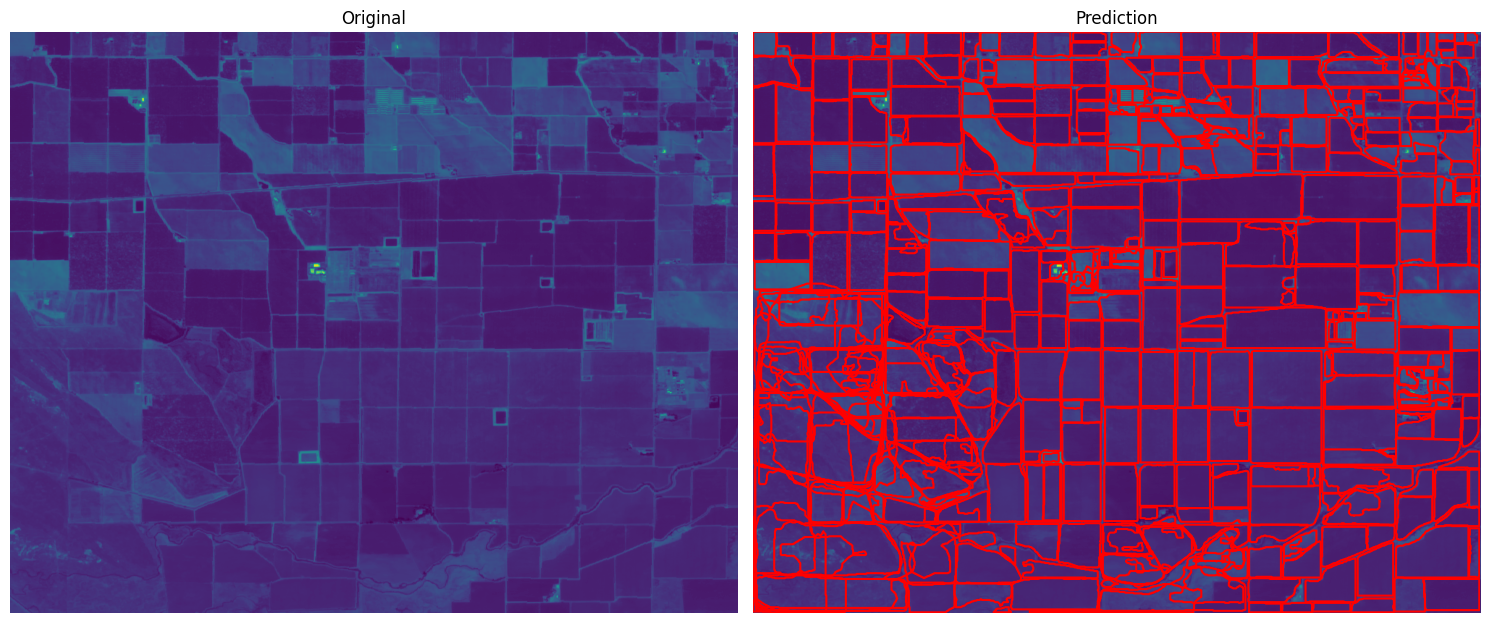

KeyboardInterrupt: 

In [ ]:
channels = [2,3,4,5,6,7]
model = CustomMRCNN(SCALED_MEAN_PER_CHANNEL[channels],
                     SCALED_STD_PER_CHANNEL[channels], len(channels), backbone='resnet101')
model.load_state_dict(torch.load('single_trainer/scaled_mask/params_0/model.pt'))
model.to('cuda')
for f in TEST_IMG_FILE_NAMES:
  visualize_prediction(model, [2,3,4,5,6,7], TEST_PATH, f, threshold=0.1)

# Conclusion

After experimenting with different backbones, Mask R-CNN settings, optimizers, learning rate schedulers, it seems like the score is capped at around 0.39. For images with many tiny fields, Mask R-CNN still has trouble capturing all the fields, this occurs in both training data and validation data.

Next, we'll try to reformulate the problem by treating it as boundary prediction. Instead of predicting fields, we will build models to predict the boundaries and then form polygons from those boundaries instead.
